### head

In [1]:
import visualization as viz
import pandas as pd
import numpy as np
import warnings
import operator

from functools import reduce
from tqdm.notebook import tqdm
from test_flow import ABCore as tf

warnings.filterwarnings("ignore")

In [2]:
path = r"C:\Users\repin\Desktop\GitHub\TestLab\development\test-data.csv"
df = pd.read_csv(path)

In [3]:
# добавим данные по месяцу и дате в удобном формате
df['month'] = df['Date'].apply(lambda x: x[:7])
df['dt'] = df['Date'].apply(lambda x: x[:10])

In [4]:
df = df[(df['OrderSource'] == 'web') & (df['Category'] == 'пицца')]

In [5]:
df = df[["dt", "CityName", "rto"]]
df = df[~df["CityName"].isin(["Москва", "Санкт-Петербург"])]

In [6]:
df_pivot = df.pivot_table(
    values="rto",
    columns="dt",
    index="CityName"
)

In [7]:
cols = list(df_pivot.columns)

wrong_cities = []
for i in cols:
    one_row = df_pivot.loc[:, i]
    if one_row.isnull().values.any():
        all_cities = list(one_row[one_row.isnull().values].index)
        for i in all_cities:
            if i not in wrong_cities:
                wrong_cities.append(i)

In [8]:
# убираем города, где есть пропуски в данных
test_wo_denied_ = [i for i in set(df["CityName"]) if i not in wrong_cities]

In [9]:
len(test_wo_denied_)

196

In [10]:
df_clean = df[df["CityName"].isin(test_wo_denied_)]

In [11]:
df_clean.shape

(35476, 3)

In [12]:
len(set(df_clean["dt"])), len(set(df_clean["CityName"]))

(181, 196)

In [13]:
knn_period_days = 56
validation_days = 14
test_days = 14

validation_min_start_date = sorted(list(set(df_clean["dt"].tolist())))[knn_period_days+test_days+1]
validation_max_start_date = sorted(list(set(df_clean["dt"].tolist())))[-validation_days-test_days-1]

validation_min_start_date, validation_max_start_date

('2022-03-13', '2022-06-02')

In [14]:
date_list = pd.date_range(
    start=validation_min_start_date,
    end=validation_max_start_date,
    freq="D",
)
date_list_str = [str(i)[:10] for i in date_list]
len(date_list_str)

82

In [15]:
unit_list = list(set(df_clean["CityName"]))

In [16]:
np.random.choice(date_list_str, 1)[0], list(np.random.choice(unit_list, 3))

('2022-05-19', ['Владивосток', 'Оренбург', 'Всеволожск'])

### VAL

In [17]:
# default params
test_params = {
    "target_metric": "rto",
    "id_field": "CityName",
    "time_series_field": "dt",
    "number_of_neighbors": 3,
    "test_units": [],
    "alpha": 0.05,
    "cuped_time": 14,
    "start_of_test": "2022-04-07",
    "days_for_knn": 56,
    "days_for_validation": 14,
    "days_for_test": 14,
    "n_iter_bootstrap": 100_000,
}

In [18]:
df_clean.head(2)

,dt,CityName,rto
7,2022-01-01,Абакан,39132.1742
30,2022-01-01,Азов,9856.7700


In [57]:
save_path = "C:/Users/repin/Desktop/GitHub/TestLab/development/graphs-cuped"
n_tests = 100
n_test_units = 5
skip = 0
saving_result = dict()

for i in tqdm(range(n_tests)):
    
    test_params["test_units"] = list(np.random.choice(unit_list, n_test_units, replace=False))
    test_params["start_of_test"] = np.random.choice(date_list_str, 1, replace=False)[0]
    # instance
    exp = tf(params_dict=test_params)
    exp.create_periods(verbose=False)
    # data
    knn_data_clean = df_clean[
        (df_clean['dt'] >= exp.start_of_knn) & (df_clean['dt'] < exp.start_of_validation)]
    # knn
    knn_pre_exp_clean_scld = exp.get_scaled_data(knn_data_clean)
    knn_vectors, ids_dict = exp.get_vectors(knn_pre_exp_clean_scld)
    all_neighbours_dtw = exp.get_all_neighbors_dtw(knn_vectors)
    all_groups_dtw = exp.get_test_control_groups(all_neighbours_dtw)
    all_units = reduce(operator.iconcat, all_groups_dtw.values(), [])
    
    # validation
    validation_data = df_clean[
        (df_clean['dt'] >= exp.start_of_validation)
        & (df_clean['dt'] < exp.start_of_test)
        & (df_clean["CityName"].isin(all_units))
    ]
    # cuped
    pilot_df_sort, pre_pilot_df_sort = exp.sort_merge_for_cuped(
        knn_data_clean,
        validation_data,
        all_groups_dtw
    )
    cuped_df = exp.calculate_cuped_metric(
        pre_pilot_df_sort,
        pilot_df_sort
    )

    try:
        return_dict = exp.bootstrap(
            cuped_df,
            np.mean,
            0,
            is_cuped=True,
            directory_path=save_path,
            test_id=f"test{i}"
        )
    except AssertionError:
        skip =+ 1
        continue
    return_dict["test_units"] = test_params["test_units"]
    return_dict["control_units"] = all_groups_dtw["control_units"]
    return_dict["start_of_test"] = test_params["start_of_test"]
    saving_result[i] = return_dict
    

  0%|          | 0/100 [00:00<?, ?it/s]

Theta is: 1.077991774764927
Theta is: 0.5801690419152055
Theta is: 0.6101068140974956
Theta is: 0.668618536939285
Theta is: 0.9383937928424476
Theta is: 0.9297602991210063
Theta is: 0.7989901533373562
Theta is: 0.8864420771811357
Theta is: 0.7334081976876898
Theta is: 0.7033065119182543
Theta is: 0.35168545167947074
Theta is: 0.8946359071541178
Theta is: 0.912283481663867
Theta is: 0.7654830082500886
Theta is: 0.915682219192777
Theta is: 0.8916666418679029
Theta is: 1.0656726986919538
Theta is: 0.7822528222222296
Theta is: 0.7043307522021799
Theta is: 0.11034500552770506
Theta is: 0.8516803243317758
Theta is: 0.7901390203452107
Theta is: 0.3375798735182962
Theta is: 0.5054434300491486
Theta is: 0.6129724301710494
Theta is: 0.619427087468028
Theta is: 0.3637626099825967
Theta is: 1.0160187070162237
Theta is: 1.0402026667578883
Theta is: 0.46355366632615275
Theta is: 0.7896894861184156
Theta is: 0.840220360170499
Theta is: 0.9604375001526961
Theta is: 0.7898116727469149
Theta is: 1.01825

In [58]:
saving_result

{0: {'aa_test': False,
  'ab_test': False,
  'pe_aa': 2537.1816335510775,
  'pe_ab': 2537.1816335510775,
  'ci_aa': (-3962.848594613987, 9104.282382530198),
  'ci_ab': (-3884.408713727424, 9111.583155132863),
  'p_value_aa_boot': 0.44323,
  'p_value_ab_boot': 0.44148,
  'test_units': ['Кингисепп',
   'Вязьма',
   'Ульяновск',
   'Голицыно',
   'Каменск-Уральский'],
  'control_units': ['Апатиты', 'Новоуральск', 'Тюмень', 'Камышин', 'Когалым'],
  'start_of_test': '2022-05-15'},
 1: {'aa_test': False,
  'ab_test': False,
  'pe_aa': -2286.8735439214106,
  'pe_ab': -2286.8735439214106,
  'ci_aa': (-6141.934167958223, 1497.8870843397383),
  'ci_ab': (-6151.694286219083, 1510.0725781548338),
  'p_value_aa_boot': 0.24399,
  'p_value_ab_boot': 0.24148,
  'test_units': ['Раменское', 'Таганрог', 'Йошкар-Ола', 'Надым', 'Череповец'],
  'control_units': ['Красное Село',
   'Домодедово',
   'Саранск',
   'Вологда',
   'Парголово'],
  'start_of_test': '2022-05-30'},
 2: {'aa_test': False,
  'ab_test':

In [59]:
len(saving_result)

90

In [60]:
np.mean([i["aa_test"] for i in saving_result.values()])

0.044444444444444446

In [61]:
np.mean([i["p_value_aa_boot"] for i in saving_result.values()])

0.5329677777777777

In [62]:
np.min([i["p_value_aa_boot"] for i in saving_result.values()])

0.02433

In [43]:
np.quantile([i["p_value_aa_boot"] for i in saving_result.values()], 0.0)

0.12244160000000001

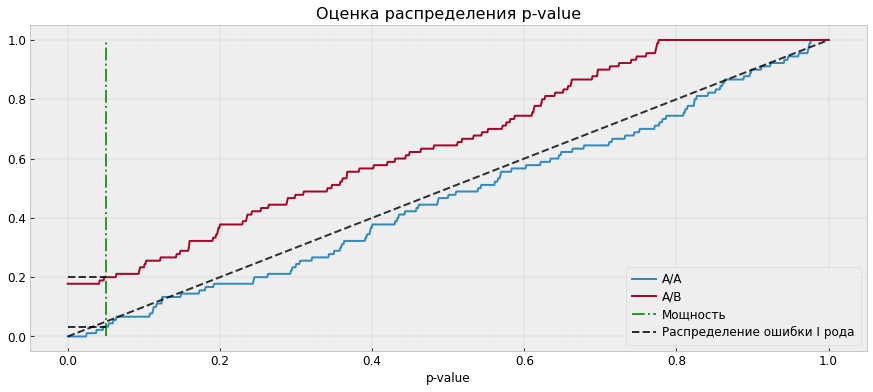

In [63]:
# a/b не смотрим
viz.plot_pvalue_distribution(
    np.array([i["p_value_aa_boot"] for i in saving_result.values()]),
    np.array([i["p_value_ab_boot"] for i in saving_result.values()]) - 0.2
)